In [89]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score



In [90]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


In [91]:
# target 컬럼 생성 = "배추가격"
target = df['배추가격']
# feature 컬럼 생성 = "배추가격"을 제외한 모든 컬럼
feature = df.drop('배추가격', axis=1)

# feature 데이터를 0~1 사이의 값으로 정규화
scaler_feature = MinMaxScaler()
feature = scaler_feature.fit_transform(feature)

# target 데이터를 0~1 사이의 값으로 정규화
scaler_target = MinMaxScaler()
target = scaler_target.fit_transform(target.values.reshape(-1,1))
target.shape


(8370, 1)

In [92]:
# feature 데이터를 3차원 배열로 변환
feature = feature.reshape(feature.shape[0], 1, feature.shape[1])
feature.shape


(8370, 1, 3)

In [93]:
# train 데이터와 test 데이터로 분리 (train : test = 8 : 2)
train_size = int(len(feature) * 0.8)
test_size = len(feature) - train_size
train_feature, test_feature = feature[0:train_size,:], feature[train_size:len(feature),:]
train_target, test_target = target[0:train_size,:], target[train_size:len(feature),:]

print(len(train_feature), len(test_feature))

6696 1674


In [94]:
#  lstm 모델 생성
model = Sequential()
model.add(LSTM(50, input_shape=(1, 3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10800     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [98]:
#  모델 학습 early stopping 적용
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(train_feature, train_target, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])


Epoch 1/100
210/210 [==============================] - 2s 9ms/step - loss: 0.0077
Epoch 2/100
210/210 [==============================] - 2s 8ms/step - loss: 0.0077
Epoch 3/100
210/210 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 3: early stopping


In [100]:
#  모델 성능 평가
train_predict = model.predict(train_feature)
test_predict = model.predict(test_feature)

# r2 score
print('train r2 score :', r2_score(train_target, train_predict))
print('test r2 score :', r2_score(test_target, test_predict))

# rmse
print('train rmse :', np.sqrt(mean_squared_error(train_target, train_predict)))
print('test rmse :', np.sqrt(mean_squared_error(test_target, test_predict)))


53/53 [==============================] - 0s 3ms/step
train r2 score : 0.1657195334501661
test r2 score : -0.11174785618687921
train rmse : 0.08784818262276528
test rmse : 0.16347692284879806


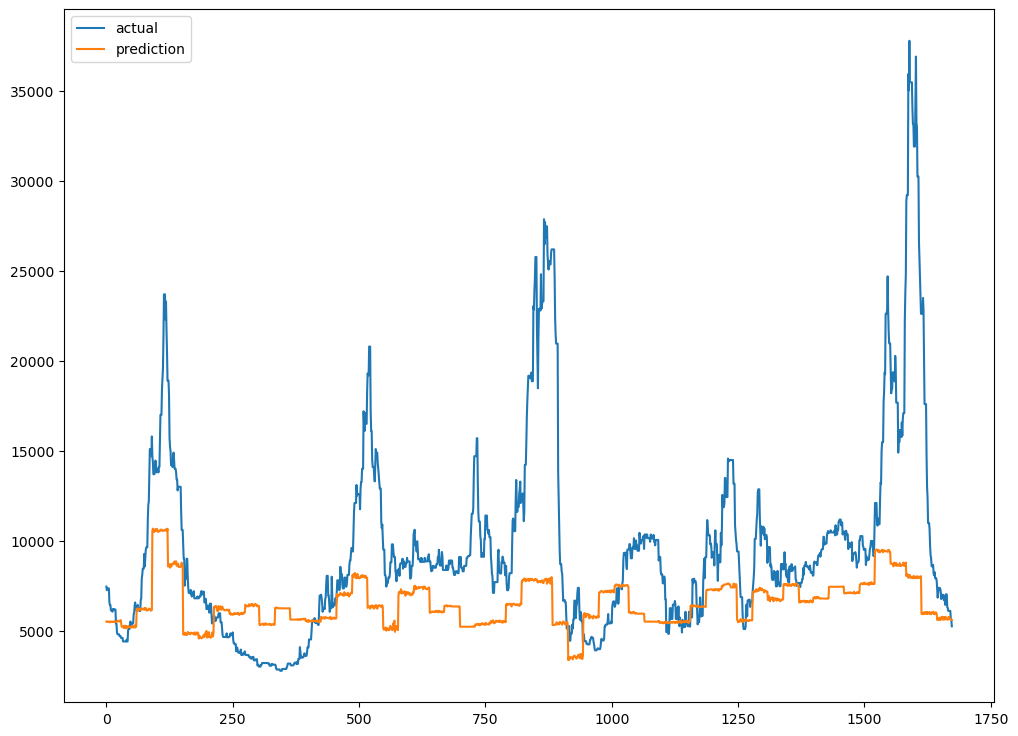

In [101]:
#  예측 결과 시각화
plt.figure(figsize=(12, 9))
plt.plot(scaler_target.inverse_transform(test_target), label='actual')
plt.plot(scaler_target.inverse_transform(test_predict), label='prediction')
plt.legend()
plt.show()


In [102]:
# 예측 결과 저장
# 예측 결과를 원래의 스케일로 변환
test_predict = scaler_target.inverse_transform(test_predict)
# 예측 결과를 데이터프레임으로 변환
test_predict = pd.DataFrame(test_predict, columns=['예측가격'])
test_predict

,예측가격
0,5503.539551
1,5490.723145
2,5504.537109
3,5488.639648
4,5488.639648
...,...
1669,5630.346680
1670,5630.346680
1671,5614.829590
1672,5594.853027
